In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from src.mssm import utils,models

In [2]:
# Initializer function
def prop_states_init(n_j,end_point,sd=5):

    # Start with equally spaced states
    start = np.array(range(0,
                                end_point,
                                round(end_point/n_j)))[1:(n_j - 1)]

    start = np.insert(start,0,0)
    start = np.insert(start,len(start),end_point)


    # Then make large random steps away from equally spaced states.
    prop_dur_state, prop_state = utils.prop_norm(end_point,start,sd=sd)

    rejection = utils.pre_ll_sms_dc_gamm(n_j,end_point,prop_dur_state,prop_state)

    while rejection:
        prop_dur_state, prop_state = utils.prop_norm(end_point,start,sd=sd)
        rejection = utils.pre_ll_sms_dc_gamm(n_j,end_point,prop_dur_state,prop_state)

    return prop_dur_state, prop_state

## Data structure

In [3]:
# Import some simulated data
n_s = 20
y_mat = list(np.load("./data/dcGAMM/no_rand/series.npy"))[0:n_s]
time = list(np.load("./data/dcGAMM/no_rand/time_series.npy"))[0:n_s]
trial_end = list(np.load("./data/dcGAMM/no_rand/trial_ends.npy"))[0:n_s]
cov = list(np.load("./data/dcGAMM/no_rand/covariates.npy"))[0:n_s]

In [4]:
# Since ever trial can be of different length we work with regular lists.
# Every element in y_mat should represent a pupil dilation time course in our
# case. Each time-course should be stored as np.array(). Time courses can contain
# missing values, which need to be marked as np.nan
y_mat[0][0:10]

array([        nan,         nan,         nan,         nan,         nan,
       -1.01649463,  0.55915381,  1.21507684, -0.59998462, -3.55308197])

In [5]:
# time should match y_mat and should not contain any missing values
time[0][0:10]

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [6]:
# trial-end should contain for every time series the end **sample**,
# indicating in our case when the trial was over. Note, this is not
# necessarily reflecting the length of the corresponding series
print(trial_end[0],len(time[0]))

49 151


In [7]:
# cov contains any covariates. So len(cov) == len(time) == len(y_mat).
# Importantly, cov[j].shape[0] == len(time[j]) == len(y_mat[j]), but cov[j].shape[1] can be anything
# as long as it's consistent per j. In words: for every time point we can store one or more (shape[1])
# covariates. Here we simply store 1 covariate - the series identifier.
# Note, this is a bug here - cov[j] should be an np.array, not a list. But it still works in this case...
print(cov[0][0:10])

[0 0 0 0 0 0 0 0 0 0]


## Model setup

1) Define initial parameters
    1.1) Penalties
2) Define the model
    2.1) Model matrix function
3) Run the model
4) Visualize

In [8]:
# Hyper parameters
n_j = 4 # Number of events - trial onset and end always elicit a response!
n_k = 15 # Number of basis functions
n_chains = 5 # Number of chains estimated

### Initial parameters

scalesc = np.array([10,10,10]) # Sojourn time distribution guesses
pic = None # Initial state is always the first one in left-right hsmm
Tc = None # Transition probabilities are also fixed.
sigmasc = 10 # Initial sigma estimate (standard deviation of residuals)

# Generate initial state estimates
c_state_est = [[[]] for _ in range(n_chains)]
c_state_dur_est = [[[]] for _ in range(n_chains)]
for nc in range(n_chains):

    for s in range(n_s):
        new_state_durs, new_states = prop_states_init(n_j,trial_end[s],sd=5)
        c_state_est[nc][0].append(new_states)
        c_state_dur_est[nc][0].append(new_state_durs)


### Penalties

In [9]:
# As shown in tutorial 1, we penalize the functions we estimate to make sure we don't overfit.
# For our simplest model we define penalties on n_j functions - one for every event we estimate.
# The penalties match in dimension the smooths (n_k). We also set the start_index since we have
# one unpenalized term in our model matrix - the first intercept.

lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(n_k,4,identifiable=False)[0] for _ in range(n_j)],start_index=1)]
          #utils.LambdaTerm(penalties = [utils.id_dist_pen(n_s,lambda x: 1)])]

## Defining the model

In [10]:
# The mssm.models file contains a base class and two templates. For us the sMsDCGAMM class
# is the one that matters. Apart from the parameters we defined earlier we need to provide
# a likelihood function and a prior likelihood function - defining any prior knowledge we
# have about the state estimates we want to recover.

m = models.sMsDCGAMM(n_j,y_mat,time,trial_end,
                         utils.ll_sms_dc_gamm,
                         utils.pre_ll_sms_dc_gamm,
                         cov,
                         cpus=6)

# Our estimation algorithm is stochastic so we need a convergence schedule.
# For practical purposes only the ``iter`` argument should be changed, b is
# likely at a good value for our purposes.
m.set_temp(utils.anneal_temps,100,b=0.005)
m.set_penalties(lTerms)

### Model matrix function

In [11]:
# Now the main thing that needs to be done by the user is the definition of the model matrix.
# Here we assume that there are n_j events and each of those elicits a response. We also
# want to add an intercept term. A function that achieves this looks as follows:

def create_event_matrix_time(time,cov,state_est,
                             identifiable = False, # You can generally set this to False for our purposes.
                             drop_outer_k=False, # Same
                             convolve=True, # This one is important, since it makes sure our functions are shifted to event onset!
                             min_c=0, # Minimum of covariate of interest - for us time
                             max_c=2500, # Maximum of covariate of interest - useful together with convolve to restrict possible function space
                             nk=10, # Number of bases per function to be estimated
                             deg=2): # Degree of function

  # Create intercept for series
  inter = utils.constant_basis(None,time,state_est,convolve=False,max_c=None)

  # Create matrix for first onset because depending on the
  # basis there might be different dimensions!
  matrix_first = utils.B_spline_basis(0,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)

  rowsMat, colsMat = matrix_first.shape

  # Now that dimensions are known expand for number of
  # event locations.
  event_matrix = np.zeros((rowsMat,colsMat * len(state_est)))
  event_matrix[:,0:colsMat] = matrix_first

  # And fill with the remaining design matrix blocks.
  # This results in a block-shifted matrix - see visualization section below for more explanation!
  cIndex = colsMat
  for ci in range(1,len(state_est)):
    event_matrix[:,cIndex:cIndex+colsMat] = utils.B_spline_basis(ci,time,state_est, identifiable, drop_outer_k, convolve, min_c, max_c, nk, deg)
    cIndex += colsMat

  return np.concatenate((inter,event_matrix),axis=1)

In [12]:
# Multi-processing does not like functions defined in notebooks.. so we import this function.
m.set_mat_fun(utils.create_event_matrix_time,identifiable=False,drop_outer_k=False, convolve=True, max_c=2500, nk=n_k, deg=2)

100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


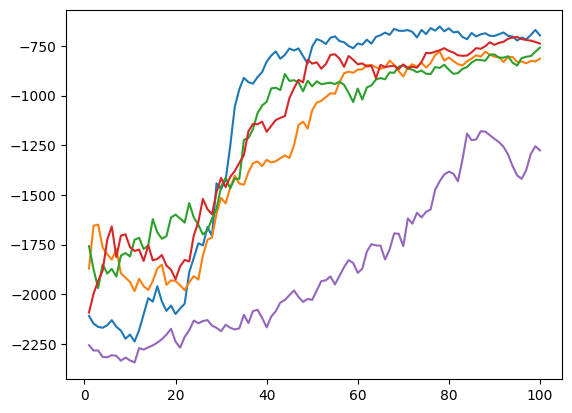

In [13]:
m.fit([[pic] for _ in range(n_chains)],
      [[Tc] for _ in range(n_chains)],
      [[np.ndarray.flatten(np.array([scp.stats.norm.rvs(size=1 + n_j*n_k)]))] for _ in range(n_chains)],
      [[sigmasc] for _ in range(n_chains)],
      [[scalesc] for _ in range(n_chains)],
      c_state_dur_est,
      c_state_est,
      n_chains=n_chains)

## Visualization

In [14]:
# We can get the best parameters with this function!
best_chain,state_est, coef_est,_,_,_,_ = m.get_last_pars_max()

In [15]:
# coef_est contains for every column in the model matrix the associated weight
np.round(coef_est)

array([ -1.,   2.,   0.,   1.,   3.,  12.,  21.,  21.,  18.,  10.,   6.,
         4.,   3.,   2.,   1.,   1.,   2.,  -0.,  -1.,   7.,  32.,  52.,
        46.,  26.,  11.,   2.,  -2.,  -2.,  -2.,  -1.,  -0.,  -0.,   1.,
         0.,  -8., -26., -33., -27., -16.,  -7.,  -2.,  -0.,  -1.,  -1.,
        -1.,   0.,  -1.,   3.,   9.,  17.,  40.,  62.,  55.,  36.,  19.,
         9.,   4.,   2.,   1.,   1.,   1.])

In [23]:
# We can simply estimate the model matrix for one series using the same function
# we passed to the model earlier.
mat_s = utils.create_event_matrix_time(time[0],
                                       [0 for _ in range(len(time[0]))],
                                       state_est[0],
                                       identifiable=False,
                                       drop_outer_k=False,
                                       convolve=True,
                                       max_c=2500,
                                       nk=n_k,
                                       deg=2)

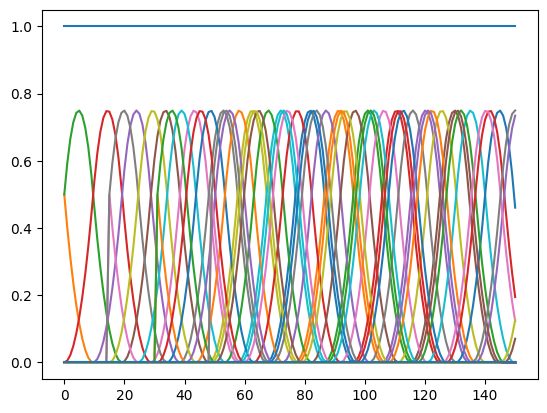

In [24]:
# Let's take a look at the columns!
for ci in range(mat_s.shape[1]):
    plt.plot(mat_s[:,ci])
plt.show()

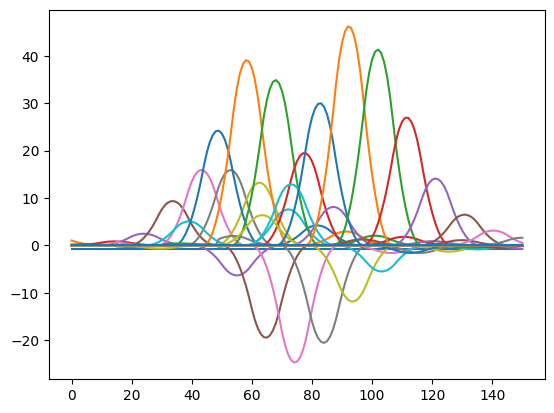

In [25]:
# Let's take a look at the columns - this time weighted by coefficients!
for ci in range(mat_s.shape[1]):
    plt.plot(mat_s[:,ci] * coef_est[ci])
plt.show()

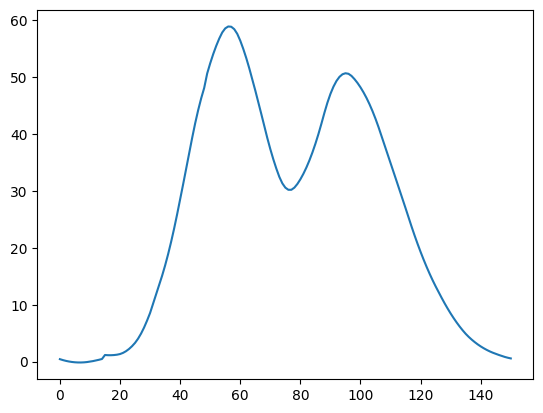

In [26]:
# The sum of all those weighted columns should result in our pupil dilation time-course for that series!
plt.plot(mat_s @ coef_est)
plt.show()

[ 0 15 31 49]


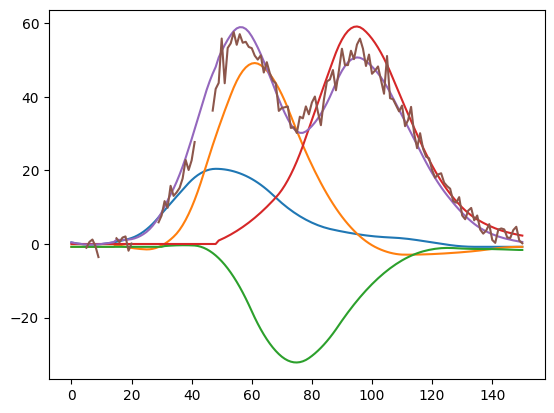

[ 0  5 18 22]


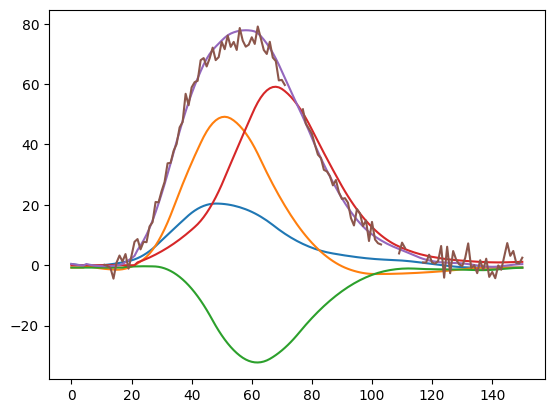

[ 0 12 45 65]


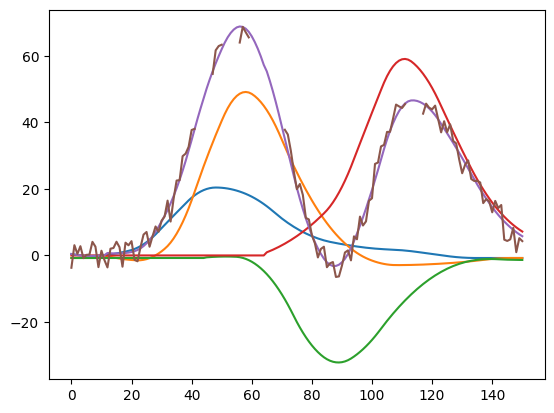

[ 0  2 26 54]


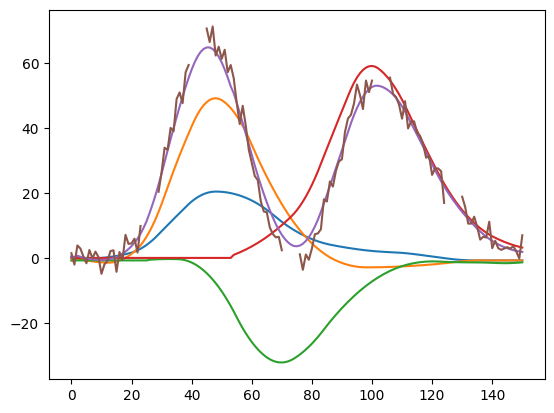

[ 0 34 38 59]


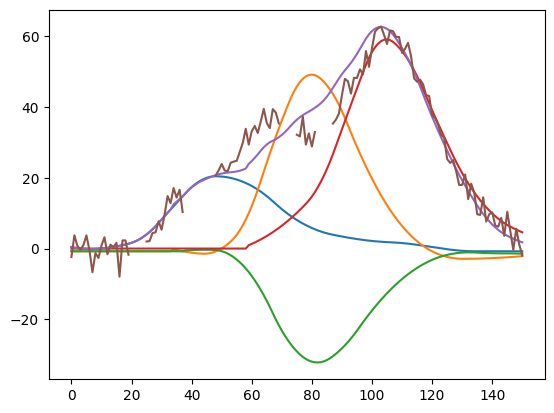

In [27]:
# We can also visualize this per event - since multiple weighted columns together reflect the response
# elicited by an individual event - and for multiple subjects!
# This can also help to identify whether the model is specified correctly and whether it converged sufficiently.
for s in range(5):
    pulse_loc_s = state_est[s]
    print(pulse_loc_s)
    mat_s = utils.create_event_matrix_time(time[s],[s for _ in range(len(time[s]))],pulse_loc_s,identifiable=False,drop_outer_k=False, convolve=True, max_c=2500, nk=n_k, deg=2)
    y_s = np.ndarray.flatten(y_mat[s])
    ii = 1
    iii = 0
    for i in range(n_k,n_k*len(pulse_loc_s),n_k):
        plt.plot(mat_s[:,ii:i] @ coef_est[ii:i] + coef_est[0])
        iii += 1
        ii += n_k
    plt.plot(mat_s[:,ii:ii+n_k] @ coef_est[ii:ii+n_k])
    plt.plot(mat_s @ coef_est)
    plt.plot(y_s)
    plt.show()